___
<h1><center> Problema de regresión</center></h1>

___


### Descripción del problema:
Inferencia del valor de las casas en Boston.

El objetivo del problema es predecir el valor de una vivienda usando sus características. 

Haremos uso del dataset Boston. La fuente es la University of California Irvine (**Url:** https://archive.ics.uci.edu/ml/machine-learning-databases/housing/)

### Descripción del dataset:

Cuenta con un total de **13 variables predictoras X** y una **variable continua a predecir Y**.

El número total de muestras es de 506 casas.

**Información de las variables:**

1. CRIM: tasa de criminalidad per cápita por ciudad
2. ZN: proporción de parcelas de más de 25,000 pies cuadrados. 
3. INDUS: proporción de acres de negocios no minoristas por ciudad
4. CHAS: variable categórica Charles River (= 1 si la casa limita con el río; 0 no limita) 
5. NOX: concentración de óxidos nítricos (partes por 10 millones)
6. RM: número promedio de habitaciones por vivienda
7. AGE: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
8. DIS: distancias ponderadas a cinco centros de empleo de Boston
9. RAD: índice de accesibilidad a carreteras radiales 
10. TAX: tasa de impuesto a la propiedad de valor total por \$ 10.000 
11. PTRATIO: ratio alumno-profesor por localidad
12. B: 1000(Bk - 0.63)^2 donde Bk es la proporción de personas de raza negra por pueblo
13. LSTAT: % menor estado de la población
14. MEDV: Valor medio de viviendas ocupadas por sus propietarios en \$1000's

# Carga de librerías:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from IPython.core.display import display, HTML
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-02-25 22:31:06.861790: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 22:31:07.292356: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 22:31:07.495205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740522667.884214     538 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740522667.998678     538 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 22:31:08.751720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Definición de funciones: 

In [3]:
def relaciones_vs_target_reg(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, int(fig_por_fila), i+1)
        sns.regplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()
    
    
def represento_historico(historico):
    hist = pd.DataFrame(historico.history)
    hist['epoch'] = historico.epoch

    plt.figure(figsize=(15,7))
    plt.xlabel('Epoch')
    plt.ylabel('Error absoluto medio [MAE]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Error de entrenamiento')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Error de validación')
    plt.title('Error MAE en entrenamiento y en test')
    plt.ylim([0,5])
    plt.legend()

    plt.figure(figsize=(15,7))
    plt.xlabel('Epoch')
    plt.ylabel('Error cuadrático medio [MSE]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Error de entrenamiento')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Error de validación')
    plt.title('Error MSE en entrenamiento y en test')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

# Lectura de datos:

In [4]:
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'

try:
    load_boston = pd.read_csv(url)
    display(load_boston.head())
    print()
    display(load_boston.info())

    X = load_boston.drop(columns=['medv'])
    Y = load_boston['medv']

    XY = pd.concat([X, pd.Series(Y, name='target')], axis=1)

except Exception as e:
    print("Failed to load from the raw URL. Try a different URL or the sklearn method.")
    print(f"Error: {e}")

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


None

In [5]:
print('- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print('- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print('- Los nombres de las variables independientes son: {}'.format(list(X.columns)))
XY[:2]

- El número de filas en el dataset es: 506
- El número de columnas en el dataset es: 14
- Los nombres de las variables independientes son: ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


# Visualizaciones y correlaciones

## Descriptivos básicos:

In [6]:
XY.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Boxplots: 

In [7]:
X_normalizado = (X-X.mean())/X.std()

In [8]:
X_normalizado[:2]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-0.419367,0.284548,-1.286636,-0.272329,-0.144075,0.413263,-0.119895,0.140075,-0.981871,-0.665949,-1.457558,0.440616,-1.074499
1,-0.416927,-0.487240,-0.592794,-0.272329,-0.739530,0.194082,0.366803,0.556609,-0.867024,-0.986353,-0.302794,0.440616,-0.491953


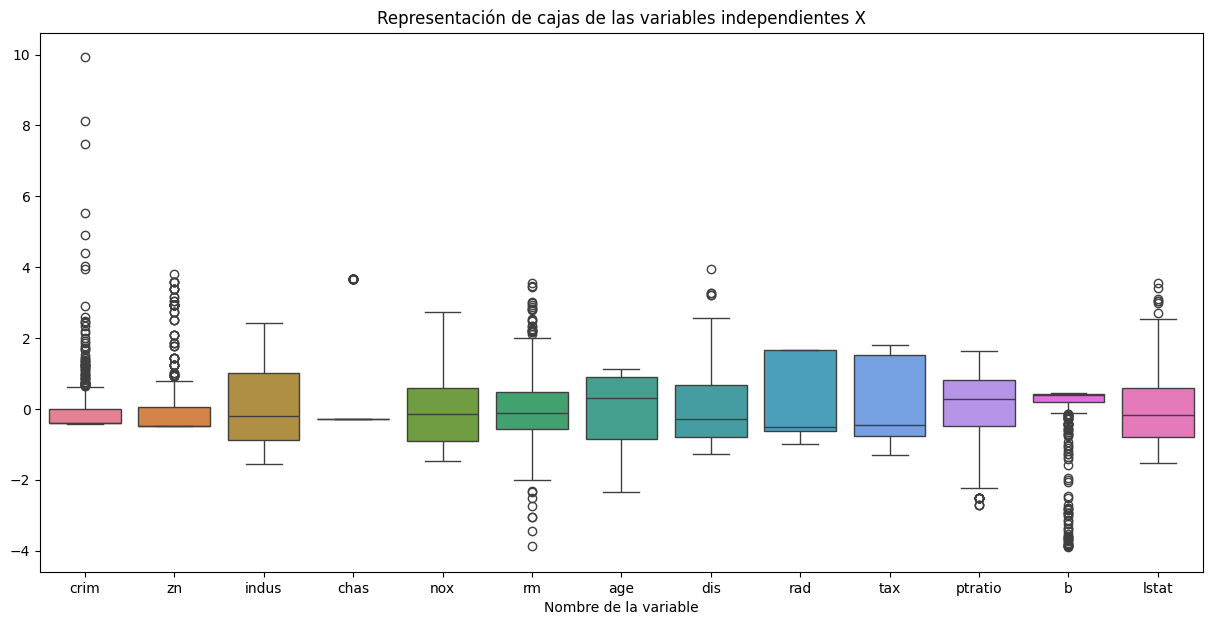

In [9]:
plt.figure(figsize=(15,7))
sns.boxplot(data=X_normalizado)
plt.title('Representación de cajas de las variables independientes X')
_ = plt.xlabel('Nombre de la variable')

## Histogramas: 

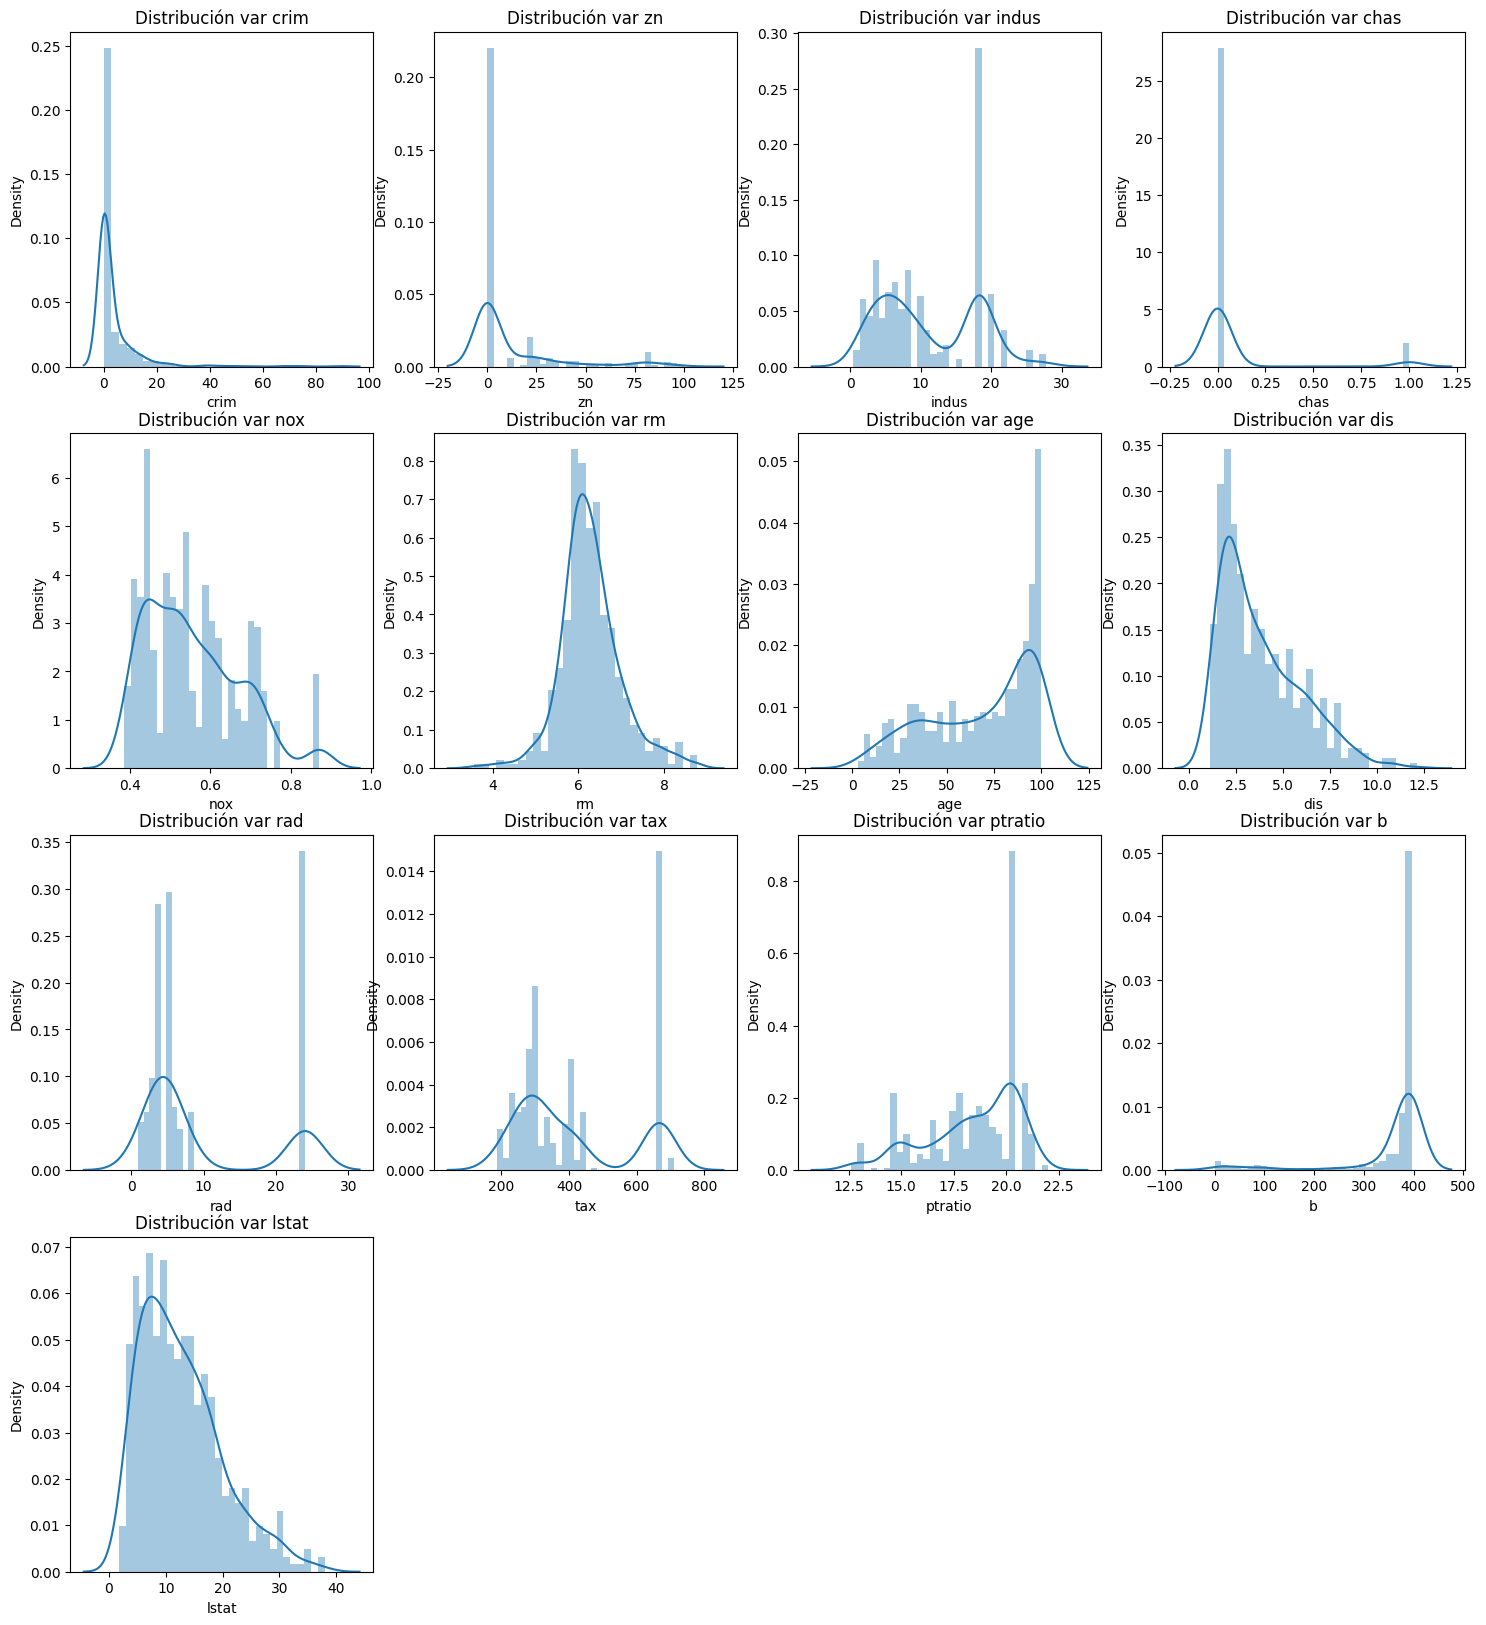

In [10]:
plt.figure(figsize=(18,20))
for i, column in enumerate(X.columns):
    plt.subplot(4, 4, i+1)
    sns.distplot(X[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Relación variable vs target: 

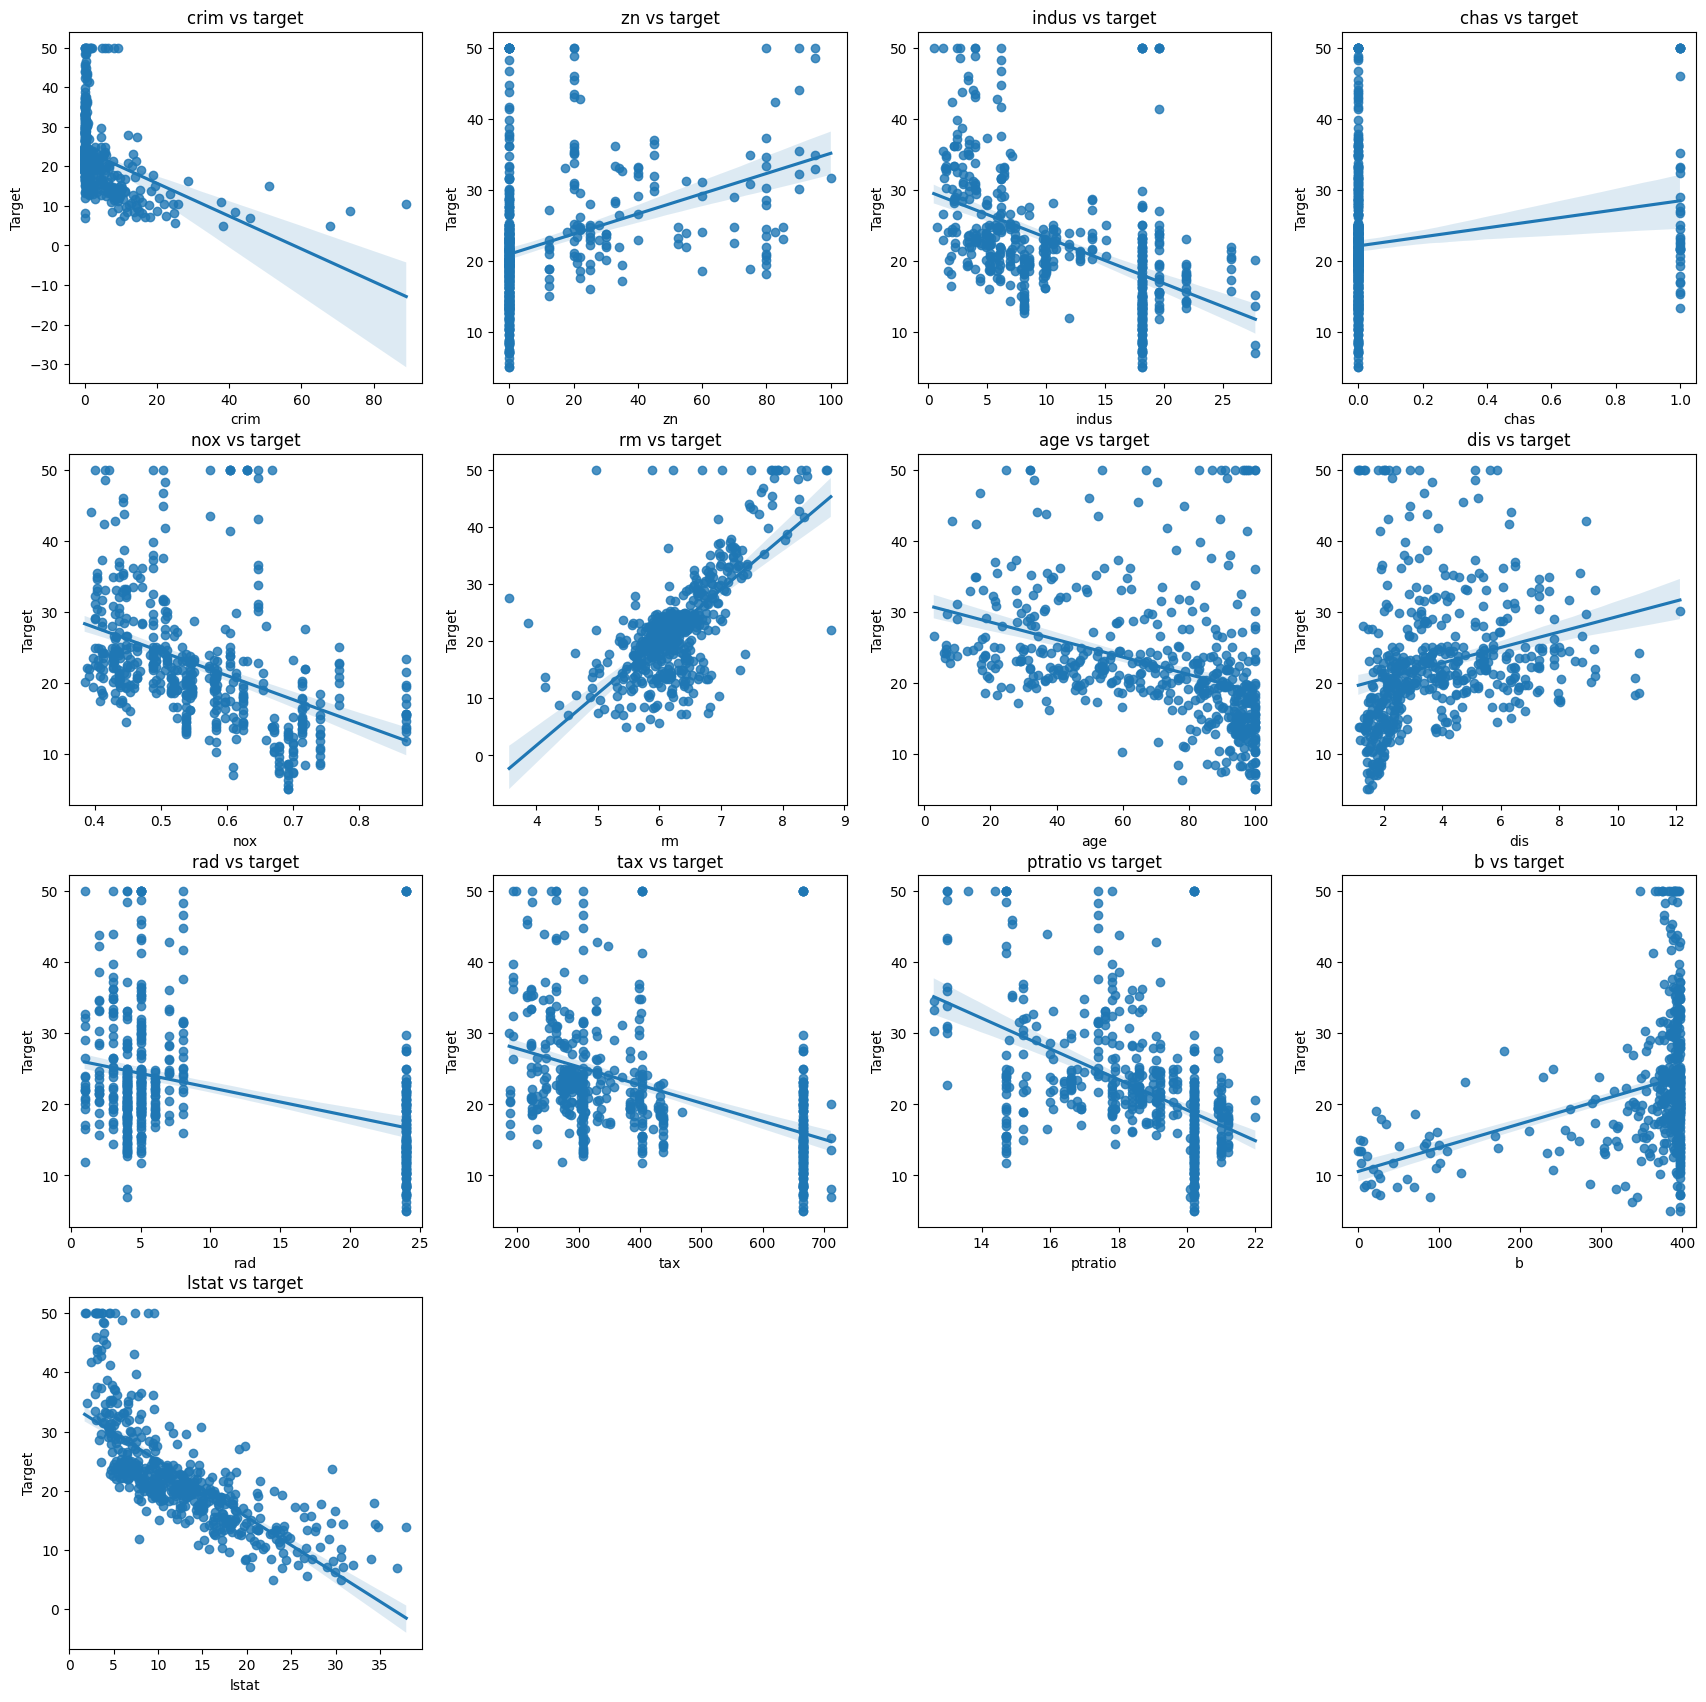

In [11]:
relaciones_vs_target_reg(X, Y)

## Matriz de correlaciones: 

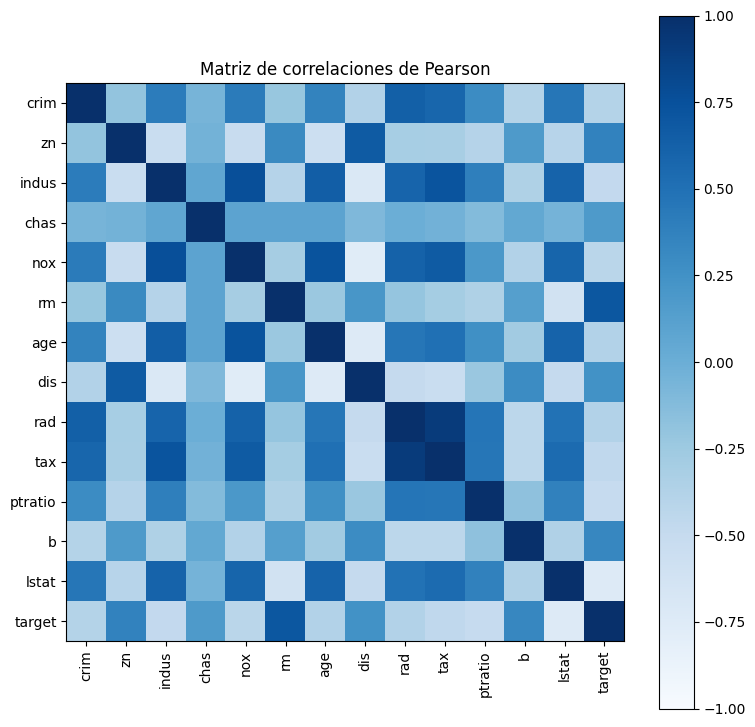

In [12]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

## Variables con mayor correlación con la target:

In [13]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
lstat,-0.737663
rm,0.695360
ptratio,-0.507787
indus,-0.483725
tax,-0.468536
nox,-0.427321
crim,-0.388305
rad,-0.381626
age,-0.376955
zn,0.360445


## Estandarización de los datos previa: 

In [14]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## División en train y test: 

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

# Modelo de regresión con NN usando Tensorflow y Keras:

In [16]:
def constructor_modelo():
    # Definición del modelo
    modelo = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])
    
    # Definición del optimizador
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    # Compilación del modelo
    modelo.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return modelo

In [17]:
model = constructor_modelo()

2025-02-25 22:33:52.549829: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
model.fit(X_train, Y_train)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 592.2550 - mae: 22.5418 - mse: 592.2550  


In [19]:
X_train.shape[1]

13

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,244 (40.02 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,123 (20.02 KB)

In [21]:
ejemplos = X_train[:10]
ejemplos_pred = model.predict(ejemplos)
ejemplos_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[2.4026968],
       [2.2222307],
       [2.3099272],
       [1.6565647],
       [3.1214514],
       [1.9967098],
       [1.0716562],
       [2.1011436],
       [2.4031088],
       [2.15508  ]], dtype=float32)

# Entrenamiento del modelo

In [22]:
# Muestro un punto por cada una de las épocas completadas
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000
historico = model.fit(X_train, Y_train, 
                    epochs=EPOCHS,
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[PrintDot()])


..................................................................................................
.................................................................................................
................................................................................................
..................................................................................................
.................................................................................................
.................................................................................................
...................................................................................................
..................................................................................................
..................................................................................................
..................................................................................................

In [23]:
hist = pd.DataFrame(historico.history)
hist['epoch'] = historico.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.451254,0.504455,0.451254,8.184990,1.996825,8.184990,995
996,0.472178,0.490472,0.472178,8.578229,2.088268,8.578229,996
997,0.542656,0.543566,0.542656,8.727087,2.177351,8.727087,997
998,0.445132,0.503281,0.445132,8.011931,2.027450,8.011931,998
999,0.478124,0.524463,0.478124,8.825619,2.108367,8.825619,999


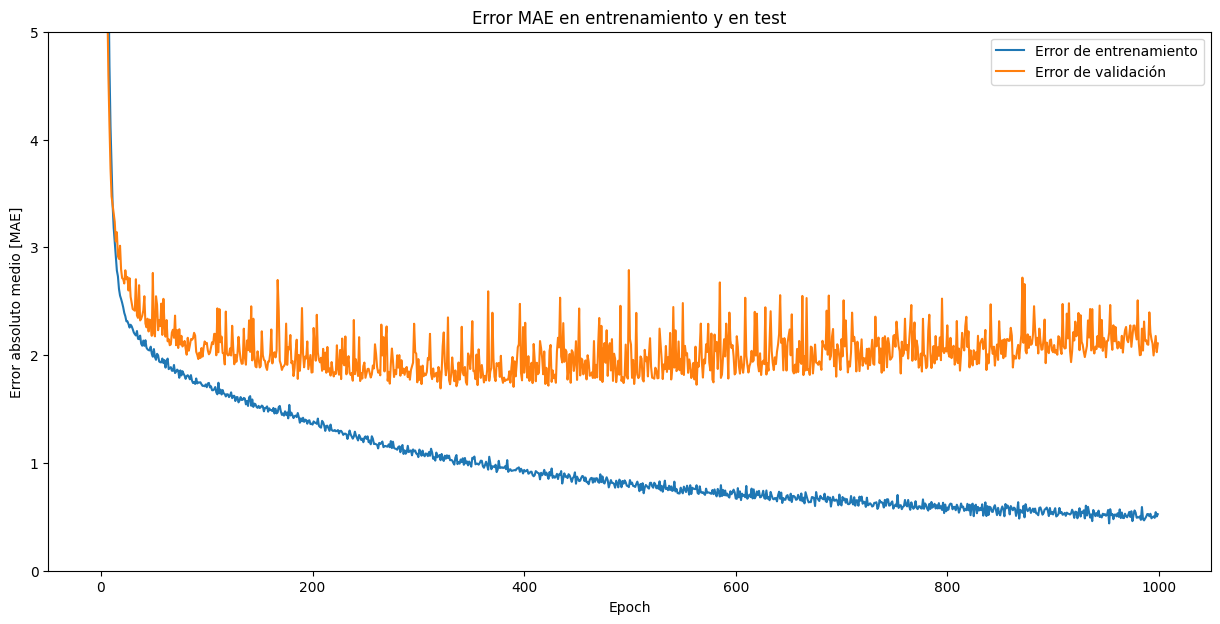

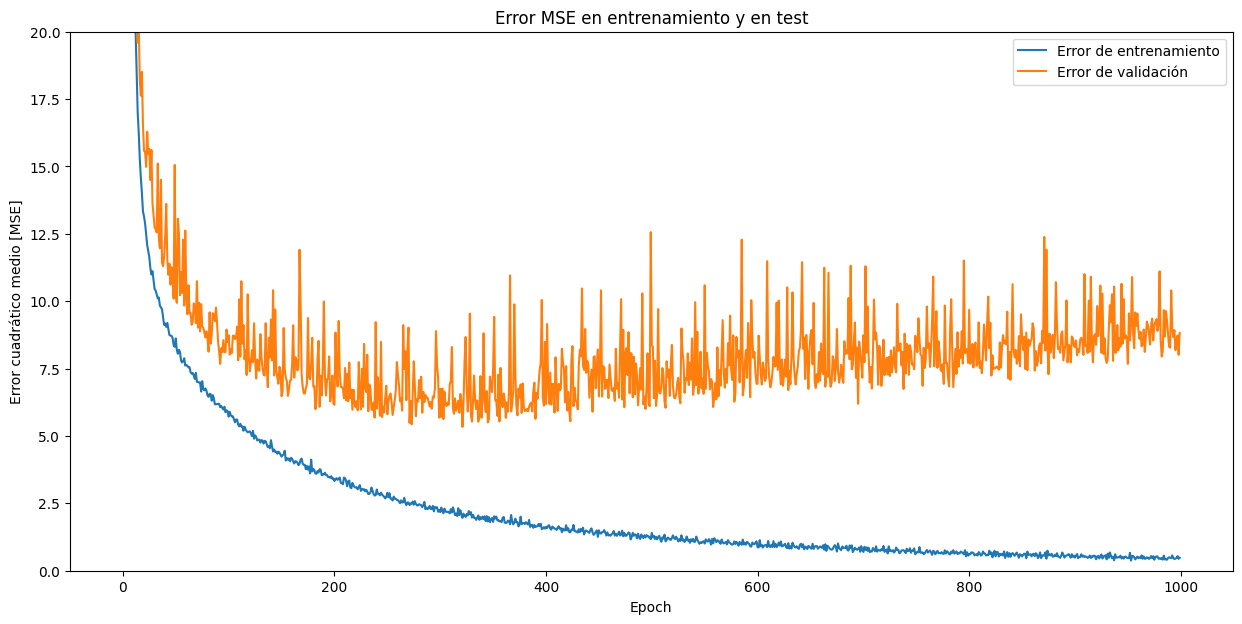

In [24]:
represento_historico(historico)


................................................................................

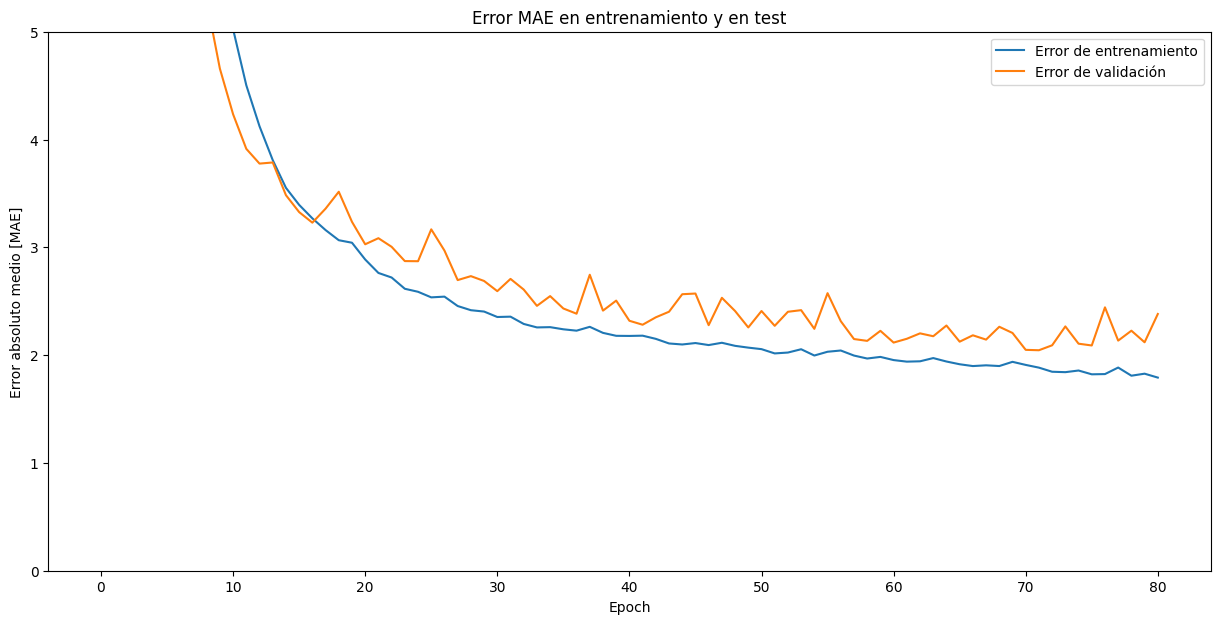

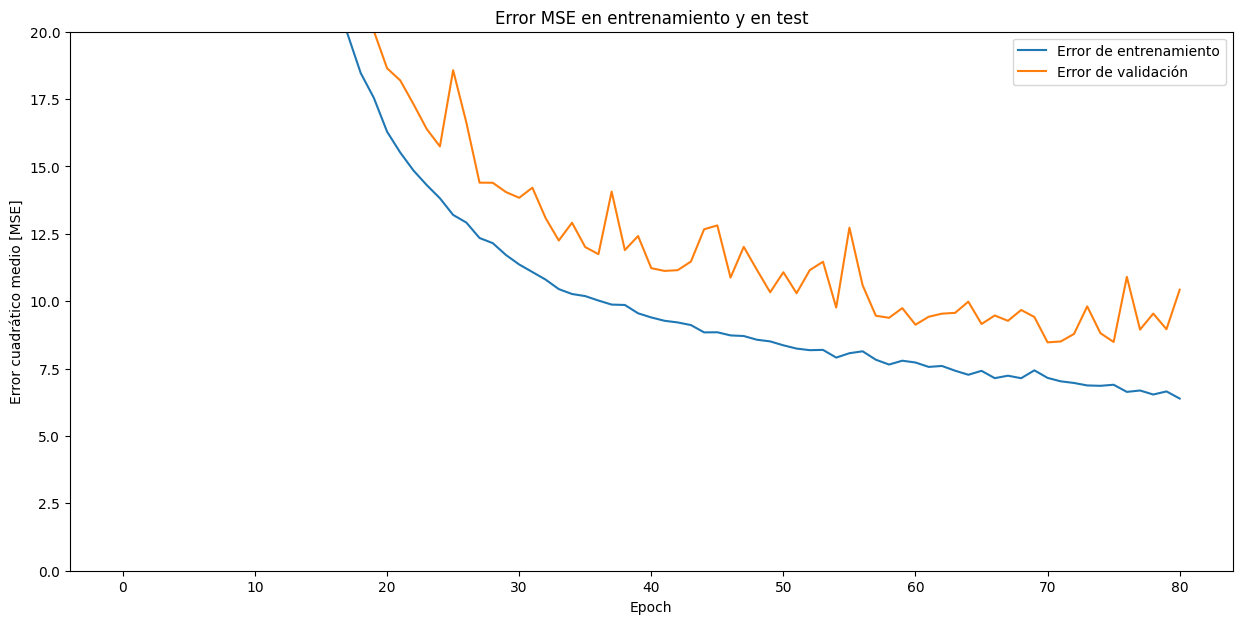

In [25]:
model = constructor_modelo()

early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=10)

history = model.fit(X_train, Y_train, 
                    epochs=EPOCHS,
                    validation_split = 0.2, 
                    verbose=0, 
                    callbacks=[early_stop, PrintDot()])

represento_historico(history)

## Analizo errores:

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


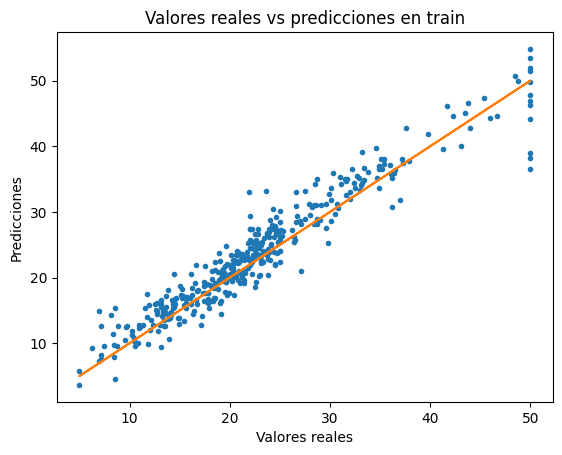

In [26]:
Y_train_pred = model.predict(X_train)
plt.title('Valores reales vs predicciones en train')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_train, Y_train_pred, '.', Y_train, Y_train, '-')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


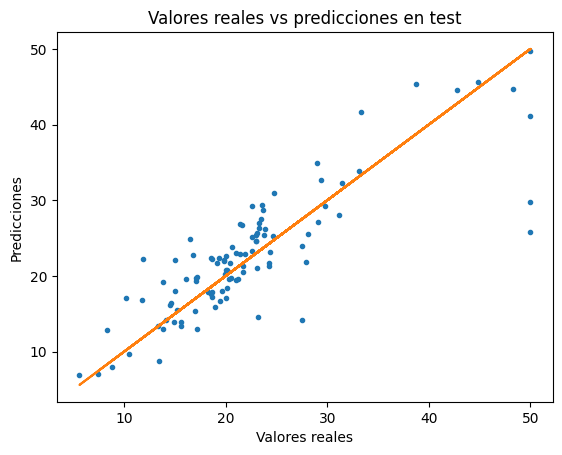

In [27]:
Y_test_pred = model.predict(X_test)
plt.title('Valores reales vs predicciones en test')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_test, Y_test_pred, '.', Y_test, Y_test, '-')

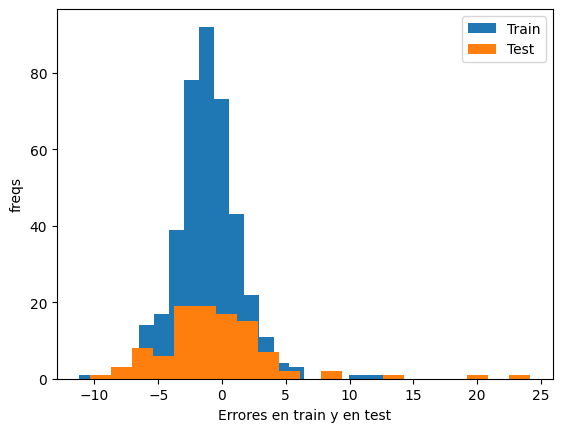

In [28]:
plt.xlabel('Errores en train y en test')
plt.ylabel('freqs')
plt.hist(Y_train - Y_train_pred.flatten(), bins=21, label='Train')
plt.hist(Y_test - Y_test_pred.flatten(), bins=21, label='Test')
_ = plt.legend()

In [29]:
error_mse_train = round(mean_squared_error(Y_train, Y_train_pred),2)
error_mse_test = round(mean_squared_error(Y_test, Y_test_pred),2)
print('El error cuadrático medio en train es: {}'.format(error_mse_train))
print('El error cuadrático medio en test es: {}'.format(error_mse_test))

El error cuadrático medio en train es: 7.93
El error cuadrático medio en test es: 24.24
